In [2]:
#@markdown Check type of GPU and VRAM available.
!nvidia-smi --query-gpu=name,memory.total,memory.free --format=csv,noheader

NVIDIA RTX A6000, 49140 MiB, 40056 MiB


In [1]:
!pip uninstall -y google-api-python-client

Found existing installation: google-api-python-client 2.97.0
Uninstalling google-api-python-client-2.97.0:
  Successfully uninstalled google-api-python-client-2.97.0


https://github.com/ShivamShrirao/diffusers/tree/main/examples/dreambooth

## Install Requirements

In [5]:
# Run for the first time only
!wget -q https://github.com/ShivamShrirao/diffusers/raw/main/examples/dreambooth/train_dreambooth.py
!wget -q https://github.com/ShivamShrirao/diffusers/raw/main/scripts/convert_diffusers_to_original_stable_diffusion.py

In [1]:
%pip install -qq git+https://github.com/ShivamShrirao/diffusers
%pip install -q -U --pre triton==2.0.0
%pip install -q accelerate transformers ftfy bitsandbytes==0.35.0 gradio natsort safetensors xformers

Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [1]:
import accelerate

ModuleNotFoundError: No module named 'accelerate'

In [2]:
#@title Login to HuggingFace 🤗

#@markdown You need to accept the model license before downloading or using the Stable Diffusion weights. Please, visit the [model card](https://huggingface.co/runwayml/stable-diffusion-v1-5), read the license and tick the checkbox if you agree. You have to be a registered user in 🤗 Hugging Face Hub, and you'll also need to use an access token for the code to work.
# https://huggingface.co/settings/tokens
!mkdir -p ~/.huggingface
HUGGINGFACE_TOKEN = "" #@param {type:"string"}
!echo -n "{HUGGINGFACE_TOKEN}" > ~/.huggingface/token

In [6]:
!pip install Pillow pyheif 

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 56.1 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python -m pip install --upgrade pip


In [12]:
def load_image(file_path):  
    if file_path.split('.')[-1] == 'heic':
        heif_file = pyheif.read(file_path)
        image = Image.frombytes(heif_file.mode, heif_file.size, heif_file.data, "raw", heif_file.mode, heif_file.stride)
    else:  
        image = Image.open(file_path)
    return image

In [22]:
import os
import re
from PIL import Image, ImageOps
import pyheif 

def crop_image(im, resoulution = 512):
    im = ImageOps.exif_transpose(im)
    (x, y) = im.size
    min_sz = min(x, y)
    x_crop = max(0, x - min_sz) / 2;
    y_crop = max(0, y - min_sz) / 3
    left = x_crop
    right = x - x_crop
    top = y_crop
    bottom = y - y_crop * 2
    img1 = im.crop((left, top, right, bottom))
    return img1.resize((resoulution, resoulution))
    
def resize_all(path, resoulution = 512):
    all_files = os.listdir(path)
    image_list = []
    idx = 1
    os.mkdir(os.path.join(path, 'cropped'))
    for x in all_files:
        if len(re.findall('.jpg|.png|.jpeg|.heic', x)) > 0:
            # im = Image.open(os.path.join(path, x))
            im = load_image(os.path.join(path, x))
            cropped = crop_image(im, resoulution)
            print(os.path.join(path,'cropped', ''.join(x.split('.')[0:-1])+'.jpg'))
            cropped.save(os.path.join(path,'cropped', ''.join(x.split('.')[0:-1])+'.jpg'))                
    return

In [27]:
resize_all('data/Drew', 512)

data/Drew/cropped/IMG_9749.jpg
data/Drew/cropped/IMG_9753.jpg
data/Drew/cropped/IMG_9752.jpg
data/Drew/cropped/IMG_9748.jpg
data/Drew/cropped/IMG_9754.jpg
data/Drew/cropped/IMG_9746 2.jpg
data/Drew/cropped/IMG_9746.jpg
data/Drew/cropped/IMG_9750.jpg


## Settings and run

In [3]:
#@markdown If model weights should be saved directly in google drive (takes around 4-5 GB).
save_to_gdrive = False #@param {type:"boolean"}
if save_to_gdrive:
    from google.colab import drive
    drive.mount('/content/drive')

#@markdown Name/Path of the initial model.
# MODEL_NAME = "runwayml/stable-diffusion-v1-5" #@param {type:"string"}
MODEL_NAME = "dreamlike-art/dreamlike-photoreal-2.0"
# MODEL_NAME = "SG161222/Realistic_Vision_V5.1_noVAE"


#@markdown Enter the directory name to save model at.

OUTPUT_DIR = "data/a9e1bcf2-ae89-40db-bac3-f0ee248c1dda/stable_diffusion_weights/a9e1bcf2-ae89-40db-bac3-f0ee248c1dda" #@param {type:"string"}

print(f"[*] Weights will be saved at {OUTPUT_DIR}")

!mkdir -p $OUTPUT_DIR

[*] Weights will be saved at data/a9e1bcf2-ae89-40db-bac3-f0ee248c1dda/stable_diffusion_weights/a9e1bcf2-ae89-40db-bac3-f0ee248c1dda


# Start Training

Use the table below to choose the best flags based on your memory and speed requirements. Tested on Tesla T4 GPU.


| `fp16` | `train_batch_size` | `gradient_accumulation_steps` | `gradient_checkpointing` | `use_8bit_adam` | GB VRAM usage | Speed (it/s) |
| ---- | ------------------ | ----------------------------- | ----------------------- | --------------- | ---------- | ------------ |
| fp16 | 1                  | 1                             | TRUE                    | TRUE            | 9.92       | 0.93         |
| no   | 1                  | 1                             | TRUE                    | TRUE            | 10.08      | 0.42         |
| fp16 | 2                  | 1                             | TRUE                    | TRUE            | 10.4       | 0.66         |
| fp16 | 1                  | 1                             | FALSE                   | TRUE            | 11.17      | 1.14         |
| no   | 1                  | 1                             | FALSE                   | TRUE            | 11.17      | 0.49         |
| fp16 | 1                  | 2                             | TRUE                    | TRUE            | 11.56      | 1            |
| fp16 | 2                  | 1                             | FALSE                   | TRUE            | 13.67      | 0.82         |
| fp16 | 1                  | 2                             | FALSE                   | TRUE            | 13.7       | 0.83          |
| fp16 | 1                  | 1                             | TRUE                    | FALSE           | 15.79      | 0.77         |


Add `--gradient_checkpointing` flag for around 9.92 GB VRAM usage.

remove `--use_8bit_adam` flag for full precision. Requires 15.79 GB with `--gradient_checkpointing` else 17.8 GB.

remove `--train_text_encoder` flag to reduce memory usage further, degrades output quality.

In [1]:
# You can also add multiple concepts here. Try tweaking `--max_train_steps` accordingly.

concepts_list = [
    {
        "instance_prompt":      "photo of X123 person",
        "class_prompt":         "photo of a person",
        "instance_data_dir":    "/workspace/ds_nickfarrell/data/a9e1bcf2-ae89-40db-bac3-f0ee248c1dda/a9e1bcf2-ae89-40db-bac3-f0ee248c1dda/cropped",
        "class_data_dir":       "/workspace/ds_nickfarrell/data/person/"
    }
    # {
#         "instance_prompt":      "photo of ukj person",
#         "class_prompt":         "photo of a person",
#         "instance_data_dir":    "/content/data/ukj",
#         "class_data_dir":       "/content/data/person"
#     }
]

# `class_data_dir` contains regularization images
import json
import os
for c in concepts_list:
    os.makedirs(c["instance_data_dir"], exist_ok=True)

with open("concepts_list.json", "w") as f:
    json.dump(concepts_list, f, indent=4)

In [5]:
#@markdown Upload your images by running this cell.

#@markdown OR

#@markdown You can use the file manager on the left panel to upload (drag and drop) to each `instance_data_dir` (it uploads faster). You can also upload your own class images in `class_data_dir` if u don't wanna generate with SD.

import os
from google.colab import files
import shutil

for c in concepts_list:
    print(f"Uploading instance images for `{c['instance_prompt']}`")
    uploaded = files.upload()
    for filename in uploaded.keys():
        dst_path = os.path.join(c['instance_data_dir'], filename)
        shutil.move(filename, dst_path)

ModuleNotFoundError: No module named 'google.colab'

In [20]:
!python3 train_dreambooth.py \
  --pretrained_model_name_or_path="dreamlike-art/dreamlike-photoreal-2.0" \
  --pretrained_vae_name_or_path="stabilityai/sd-vae-ft-mse" \
  --output_dir="data/a9e1bcf2-ae89-40db-bac3-f0ee248c1dda/stable_diffusion_weights/a9e1bcf2-ae89-40db-bac3-f0ee248c1dda" \
  --with_prior_preservation --prior_loss_weight=1.0 \
  --seed=1337 \
  --resolution=512 \
  --train_batch_size=1 \
  --train_text_encoder \
  --mixed_precision="fp16" \
  --use_8bit_adam \
  --gradient_accumulation_steps=1 \
  --learning_rate=1e-6 \
  --lr_scheduler="constant" \
  --lr_warmup_steps=30 \
  --num_class_images=69 \
  --sample_batch_size=4 \
  --max_train_steps=1204 \
  --save_interval=1204 \
  --save_sample_prompt="photo of X123 person" \
  --concepts_list="/workspace/ds_nickfarrell/data/a9e1bcf2-ae89-40db-bac3-f0ee248c1dda/concepts_list.json"

# Reduce the `--save_interval` to lower than `--max_train_steps` to save weights from intermediate steps.
# `--save_sample_prompt` can be same as `--instance_prompt` to generate intermediate samples (saved along with weights in samples directory).


===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please submit your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
For effortless bug reporting copy-paste your error into this form: https://docs.google.com/forms/d/e/1FAIpQLScPB8emS3Thkp66nvqwmjTEgxp8Y9ufuWTzFyr9kJ5AoI47dQ/viewform?usp=sf_link
/usr/local/lib/python3.10/dist-packages/bitsandbytes/cuda_setup/paths.py:27: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('/usr/local/nvidia/lib'), PosixPath('/usr/local/nvidia/lib64')}
  warn(
/usr/local/lib/python3.10/dist-packages/bitsandbytes/cuda_setup/paths.py:105: UserWarning: /usr/local/nvidia/lib:/usr/local/nvidia/lib64 did not contain libcudart.so as expected! Searching further paths...
  warn(
/usr/local/lib/python3.10/dist-packages/bitsandbytes/cuda_setup/paths.py:27: UserWarning: WARNING: The following directories listed in you

In [10]:
# #@markdown Specify the weights directory to use (leave blank for latest)
# WEIGHTS_DIR = "" #@param {type:"string"}
# if WEIGHTS_DIR == "":
#     from natsort import natsorted
#     from glob import glob
#     import os
#     WEIGHTS_DIR = natsorted(glob(OUTPUT_DIR + os.sep + "*"))[-1]
# print(f"[*] WEIGHTS_DIR={WEIGHTS_DIR}")
WEIGHTS_DIR= '/workspace/ds_nickfarrell/data/a9e1bcf2-ae89-40db-bac3-f0ee248c1dda/stable_diffusion_weights/a9e1bcf2-ae89-40db-bac3-f0ee248c1dda/1201'

## Convert weights to ckpt to use in web UIs like AUTOMATIC1111.

In [11]:
#@markdown Run conversion.
ckpt_path = WEIGHTS_DIR + "/model.ckpt"

half_arg = ""
#@markdown  Whether to convert to fp16, takes half the space (2GB).
fp16 = True #@param {type: "boolean"}
if fp16:
    half_arg = "--half"
!python convert_diffusers_to_original_stable_diffusion.py --model_path $WEIGHTS_DIR  --checkpoint_path $ckpt_path $half_arg
print(f"[*] Converted ckpt saved at {ckpt_path}")

Reshaping encoder.mid.attn_1.q.weight for SD format
Reshaping encoder.mid.attn_1.k.weight for SD format
Reshaping encoder.mid.attn_1.v.weight for SD format
Reshaping encoder.mid.attn_1.proj_out.weight for SD format
Reshaping decoder.mid.attn_1.q.weight for SD format
Reshaping decoder.mid.attn_1.k.weight for SD format
Reshaping decoder.mid.attn_1.v.weight for SD format
Reshaping decoder.mid.attn_1.proj_out.weight for SD format
[*] Converted ckpt saved at /workspace/ds_nickfarrell/data/a9e1bcf2-ae89-40db-bac3-f0ee248c1dda/stable_diffusion_weights/a9e1bcf2-ae89-40db-bac3-f0ee248c1dda/1201/model.ckpt


## Inference

In [12]:
import torch
from torch import autocast
from diffusers import StableDiffusionPipeline, DDIMScheduler, DDPMScheduler
from IPython.display import display

# model_path = WEIGHTS_DIR             # If you want to use previously trained model saved in gdrive, replace this with the full path of model in gdrive
model_path = "/workspace/ds_nickfarrell/data/a9e1bcf2-ae89-40db-bac3-f0ee248c1dda/stable_diffusion_weights/a9e1bcf2-ae89-40db-bac3-f0ee248c1dda/1201/"
pipe = StableDiffusionPipeline.from_pretrained(model_path, safety_checker=None, torch_dtype=torch.float16).to("cuda")
pipe.scheduler = DDPMScheduler.from_config(pipe.scheduler.config)
pipe.enable_xformers_memory_efficient_attention()
g_cuda = None

In [66]:
#@markdown Can set random seed here for reproducibility.


5469888410743667


  0%|          | 0/50 [00:00<?, ?it/s]

[<PIL.Image.Image image mode=RGB size=512x512 at 0x7FF69B467340>]
8278145836873029


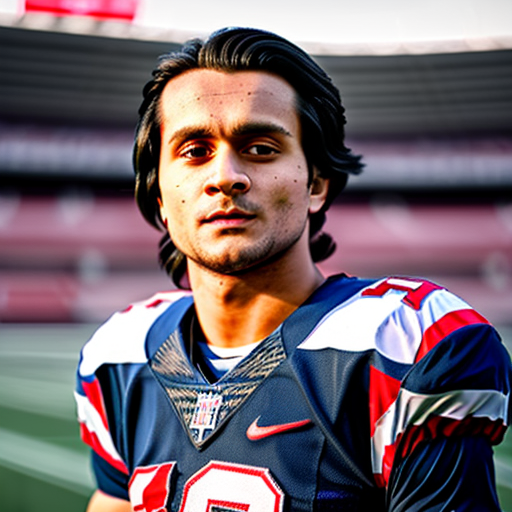

In [18]:
#@title Run for generating images.
import random
g_cuda = torch.Generator(device='cuda')
seed = random.randint(1, 1e16 -1)#@param {type:"number"}
# seed = 4856845480668637
g_cuda.manual_seed(seed)
print(seed)

prompt = "closeup portrait of X123 as a male American footballer with perfect facial features, sporty body. Standing in a stadium wearing football team jersey. Chest level portrait. Octane render, 8K HDR." #@param {type:"string"}
negative_prompt = "multiple person, person in the background, crossed eyes, ((full body)), bare body, ((logo)), blur, freckles, childish, text, symbols" #@param {type:"string"}
num_samples = 1 #@param {type:"number"}
guidance_scale = 14 #@param {type:"number"}
num_inference_steps = 50 #@param {type:"number"}
height = 512 #@param {type:"number"}
width = 512 #@param {type:"number"}


with autocast("cuda"), torch.inference_mode():
    response = pipe(
        prompt,
        height=height,
        width=width,
        negative_prompt=negative_prompt,
        num_images_per_prompt=num_samples,
        num_inference_steps=num_inference_steps,
        guidance_scale=guidance_scale,
        generator=g_cuda
    )
    images = response.images
    print(response.images)
    print(g_cuda.seed())

for img in images:
    display(img)

# a hyper detailed photo realistic horror character portrait, 1 9 8 0 by john totleben, Darrell K Sweet, Wes Wilson, Mark Brooks depicting an alien cyborg [[theCyborg Hacker]], cyberpunk, character portrait

In [84]:
import cv2
from PIL import Image
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel, UniPCMultistepScheduler
import torch
import numpy as np
from diffusers.utils import load_image
from IPython.display import display

image = load_image("https://images.unsplash.com/photo-1506794778202-cad84cf45f1d?ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D&auto=format&fit=crop&w=512&h=764&q=80")
image = np.array(image)

low_threshold = 100
high_threshold = 200

image = cv2.Canny(image, low_threshold, high_threshold)
image = image[:, :, None]
image = np.concatenate([image, image, image], axis=2)
image = Image.fromarray(image)

controlnet = ControlNetModel.from_pretrained(
    "lllyasviel/sd-controlnet-canny", torch_dtype=torch.float16
)

pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", controlnet=controlnet, safety_checker=None, torch_dtype=torch.float16
)

pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)

# Remove if you do not have xformers installed
# see https://huggingface.co/docs/diffusers/v0.13.0/en/optimization/xformers#installing-xformers
# for installation instructions
pipe.enable_xformers_memory_efficient_attention()

pipe.enable_model_cpu_offload()

image = pipe("a potrait of a superhero, wearing superhero suite, rainbow background", image, num_inference_steps=50, guidance_scale=20.0).images[0]

display(image)


ModuleNotFoundError: No module named 'cv2'

In [123]:
!pip install opencv-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.7/61.7 MB 30.0 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python -m pip install --upgrade pip


In [ ]:
!python test_script.py